In [486]:
import pandas as pd
import numpy as np
from scipy.linalg import diagsvd
import matplotlib.pyplot as plt
import os
os.chdir('/Users/sosuke/Downloads')
from pca import pca
from scipy.linalg import fractional_matrix_power
from sklearn.cross_decomposition import CCA
from scipy.spatial import distance_matrix

In [309]:
# Fama French Industry return data

FF = pd.read_csv("FamaFrench30.csv", index_col=0)

In [322]:
FF

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
date,,,,,,,,,,,,,,,,,,,,,
192607,0.56,-5.19,1.29,2.93,10.97,-0.48,8.08,1.77,8.14,0.39,...,0.83,9.22,2.06,7.70,1.93,-23.79,0.07,1.87,0.37,5.20
192608,2.59,27.03,6.50,0.55,10.01,-3.58,-2.51,4.25,5.50,8.14,...,2.17,2.02,4.39,-2.38,4.88,5.39,-0.75,-0.13,4.46,6.76
192609,1.16,4.02,1.26,6.58,-0.99,0.73,-0.51,0.69,5.33,2.31,...,2.41,2.25,0.19,-5.54,0.05,-7.87,0.25,-0.56,-1.23,-3.86
192610,-3.06,-3.31,1.06,-4.76,9.47,-4.68,0.12,-0.57,-4.76,1.00,...,-0.11,-2.00,-1.09,-5.08,-2.64,-15.38,-2.20,-4.11,-5.16,-8.49
192611,6.35,7.29,4.55,1.66,-5.80,-0.54,1.87,5.42,5.20,3.11,...,1.63,3.77,3.64,3.84,1.60,4.67,6.52,4.33,2.24,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201705,1.69,4.34,6.18,2.86,-1.65,1.83,-2.11,-0.44,-0.57,-0.08,...,-1.94,3.66,4.63,2.66,2.74,2.62,0.51,6.99,-0.97,-0.68
201706,-2.59,-1.14,-0.94,-0.14,2.75,-0.13,9.44,5.55,1.99,4.45,...,-2.27,-0.76,-3.38,1.93,3.44,0.21,-2.39,-2.48,5.76,1.37
201707,1.59,1.25,-5.99,5.05,2.41,1.86,1.32,0.52,1.10,1.29,...,5.32,4.05,3.12,-2.35,-4.42,-0.92,1.00,-2.56,1.93,1.51


A formula to compute the distance between two industries i and j is $(R^i-R^j)^T(R^i-R^j)\in\mathbb{R}$ for $i, j=1,2,..., 30$ where $R^i = [R^i_1, R^i_2, ..., R^i_{1095}]^T\in\mathbb{R}^{1095}, i = 1,2, ..., 30$ is the i-th column of the data matrix.

Using a distance_matrix function from scipy,

In [500]:
dist_mat = distance_matrix(np.transpose(FF), np.transpose(FF), p=2)

In [534]:
dist_mat

array([[  0.        , 171.04428199, 145.62951418, 215.31847877,
        162.95333841, 116.03760942, 156.28109867, 116.96350927,
        141.24339135, 185.73943685, 145.9437789 , 216.37243378,
        165.47651283, 169.73703279, 198.55238629, 179.39094737,
        210.93216564, 311.29856456, 164.79144911, 132.11246308,
        129.26022397, 254.95594463, 174.01928801, 126.61933383,
        165.949373  , 176.07378595, 117.40864023, 146.75184292,
        136.48595679, 155.47813544],
       [171.04428199,   0.        , 228.07421468, 230.23251964,
        213.9096218 , 183.68002178, 219.998915  , 186.30368622,
        198.52595397, 216.74074098, 185.71711984, 250.65468099,
        206.60639656, 214.90024779, 237.14282089, 214.63433835,
        251.88524987, 333.82561241, 222.32528669, 200.71824456,
        208.60936101, 296.68163593, 223.44480616, 193.64618535,
        209.50032267, 197.95125334, 186.08316958, 195.3975788 ,
        188.91818388, 201.1013804 ],
       [145.62951418, 228.0742

The Gram matrix G is calculated as below.

In [547]:
G = np.zeros((30, 30))
total_sum_d = np.trace(np.dot(np.transpose(dist_mat), dist_mat))/900
                  
for i in range(30):
    row_sum_d = sum(np.power(dist_mat[i, :], 2))/30
    
    for j in range(30):
        col_sum_d = sum(np.power(dist_mat[:, j], 2))/30
        G[i, j] = (dist_mat[i, j]**2 - row_sum_d - col_sum_d + total_sum_d)/(-2)

In [620]:
eigval_g, eigvec_g = np.linalg.eigh(G)
eigval_g = np.append(np.flip(eigval_g)[:29], np.zeros(1)) # The last eigenvalue is zero
eigvec_g = np.flip(eigvec_g, axis=1)
recover_x = np.dot(eigvec_g, np.diag(np.power(eigval_g, 0.5)))

In [622]:
recover_x

array([[ 5.53874299e+01, -2.25490488e+01,  4.74087469e+01,
        -7.05853472e+00,  1.03056077e+01, -2.19999333e+00,
         2.79455466e+00, -3.68397528e-01, -2.50387526e+00,
        -6.55815514e-01,  9.84782154e+00, -4.44712683e+00,
        -6.48966204e+00, -4.05647171e+00, -4.62782745e+00,
         3.23121499e+00,  7.46322411e+00,  1.10882585e-01,
         8.45446366e+00,  1.30694317e+01, -7.55854112e-01,
        -4.74082595e+00, -8.38270518e+00, -5.75360888e+00,
         7.85237876e+00,  8.09994150e+00, -8.81616742e-01,
        -1.45942245e+00, -5.41944076e+01,  0.00000000e+00],
       [ 3.96332906e+01,  1.20611410e+01,  5.17757998e+01,
        -6.75539126e+01, -7.06887347e+01,  4.25701088e+00,
        -8.89571741e+01, -4.96213411e+01, -5.76142262e+00,
         2.70099754e+01,  2.28700923e+01,  6.33876929e-01,
         1.69533102e+01, -3.33311482e+00, -1.05546759e+01,
         8.71272140e+00, -2.11475382e+01, -5.18517635e+00,
         2.00288489e+00, -7.99300827e+00, -2.02908638e+

To plot the first two dimensions,

Text(0, 0.5, '$q_2$')

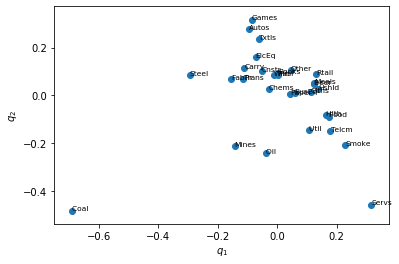

In [645]:
fig8, ax8 = plt.subplots()
ax8.scatter(eigvec_g[:, 0], eigvec_g[:, 1])
for i, txt in enumerate(FF.columns.values):
    ax8.annotate(str(txt), (eigvec_g[i, 0], eigvec_g[i, 1]), fontsize=7.5)
ax8.set_xlabel('$q_1$')
ax8.set_ylabel('$q_2$')

"Closer" in distance means that returns of two industries are similar over time, i.e. they co-move often. On the other hand, "further" in distance means that two industries do not move together that often.

From the plot in (e), we can see that Autos is the closest to Games, meaning that Autos co-moves with Games the most.
Also from the plot, we can see that Coal, Servs, and Steel tend to move on its own.

In order to diversify your portfolio, you should pick industries that are far away from each other in the plot. This gives you industries that do not move together and lowers the risk of your portfolio.